#Майнор ИАД. Домашнее задание 3. YOLO.

В этом задании вы напишете и обучите свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на котрой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

Баллы за ДЗ распределены следующим образом: 
- Выборка для YoloV1 - 2 балла
- YOLO модель - 2 балла
- YOLO Loss - 3 балла
- Вспомогательные функции - 2 балла
- Обучение и расчет метрик - 2 балла

Для построения и обучения можно использовать как pytorch, так и pytorch-lightning.

Да-да, баллов в сумме получается 11

In [1]:
# Данная библиотека понадобится нам, чтобы обработать разметку
! pip install xmltodict pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 33.5 MB/s 
     |████████████████████████████████| 125 kB 77.9 MB/s 
     |████████████████████████████████| 512 kB 71.0 MB/s 


In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 30.7 MB/s 
     |████████████████████████████████| 174 kB 73.9 MB/s 
     |████████████████████████████████| 182 kB 74.8 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 173 kB 77.7 MB/s 
     |████████████████████████████████| 168 kB 78.3 MB/s 
     |████████████████████████████████| 168 kB 84.1 MB/s 
     |████████████████████████████████| 166 kB 85.1 MB/s 
     |████████████████████████████████| 166 kB 75.9 MB/s 
     |████████████████████████████████| 162 kB 82.5 MB/s 
     |████████████████████████████████| 162 kB 79.1 MB/s 
     |████████████████████████████████| 158 kB 74.5 MB/s 
     |████████████████████████████████| 157 kB 57.3 MB/s 
     |████████████████████████████████| 157 kB 61.6 MB/s 
     |████████████████████████████████| 157 kB 78.0 MB/s 
     |███████████████████████████

Скачаем данные

In [3]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

total 12
drwx------ 4 root root 4096 Nov 26 08:32 data
drwxr-xr-x 3 root root 4096 Dec 19 18:24 __MACOSX
drwxr-xr-x 1 root root 4096 Dec 16 21:15 sample_data


Посмотрим как выглядит один из файлов разметки

In [4]:
!cat data/train/apple_3.xml

<annotation>
	<folder>train</folder>
	<filename>apple_3.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_3.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1000</width>
		<height>708</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>584</xmin>
			<ymin>438</ymin>
			<xmax>867</xmax>
			<ymax>708</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>492</xmin>
			<ymin>141</ymin>
			<xmax>740</xmax>
			<ymax>394</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>176</xmin>
			<ymin>199</ymin>
			<xmax>490</xmax>
			<ymax>466</ymax>
		</bndbox>
	</object>
	<obj

## Релизуйте выборку для YoloV1 - 2 балла

In [5]:
import os
import cv2
import json
import glob
import tqdm
import xmltodict

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import auc
# Добавьте необходимые вам библиотеки, если их не окажется в списке выше

import wandb
from pytorch_lightning.loggers import WandbLogger

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
# globals
class2tag = {"apple": 1, "orange": 2, "banana": 3}
tag2class = {v: k for k, v in class2tag.items()}
device = 'gpu' if torch.cuda.is_available() else 'cpu'

Так как в этом домашнем задании использовать аугментации для обучения __обязательно__ - советуем воспользоваться библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Для знакомства с этим механизмом советуем следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). 

Вы все еще можете избрать путь torchvision.transforms, вам потребуется знакомый нам метод `__getitem__`, однако вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную

__Обратите внимание__ на то, что в статье коробки предсказаний параметризуются через: _(x_center, y_center, width, height)_ (причем эти значения _относительные_), а в наших файлах - это _(x_min, y_min, x_max, y_max)_

Также, помните что модель должна предсказывать как прямоугольник с обьектом, так и вероятности каждого класса!

In [7]:
from torch.nn.modules import transformer
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None, S=7, B=2, C=3):
        self.image_paths = sorted(list(filter(lambda x: x.endswith('jpg'), os.listdir(data_dir))))
        self.box_paths = sorted(list(filter(lambda x: x.endswith('xml'), os.listdir(data_dir))))
        self.data_dir = data_dir

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms
        
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        self.S = S
        self.B = B
        self.C = C


    def __len__(self):
        return len(self.image_paths)

    def __get_boxes_from_xml(self, xml_filename: str, im_h, im_w):
      """
      Метод, который считает и распарсит (с помощью xmltodict) переданный xml
      файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
      и название класса обьекта в каждом прямоугольнике

      Обратите внимание, что обьектов может быть как несколько, так и один единственный
      """
      bounds = []
      labels = []

      with open(self.data_dir + '/' + xml_filename, 'rb') as xml:
        raw = xmltodict.parse(xml, process_namespaces=True)['annotation']

        objects = raw['object']
        # single object in image
        if type(objects) is dict:
          objects = [objects]

        bounds = []
        labels = []
        for obj in objects:
          bndbx = obj['bndbox']
          bounds.append([(float(bndbx['xmax']) + float(bndbx['xmin']))/(2 * im_w), # center_x
                              (float(bndbx['ymax']) + float(bndbx['ymin']))/(2 * im_h), # center_y
                              (float(bndbx['xmax']) - float(bndbx['xmin']))/im_w, # width
                              (float(bndbx['ymax']) - float(bndbx['ymin']))/im_h # height
                              ])
          labels.append(class2tag[obj['name']])

      return bounds, labels

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        image = np.array(Image.open(self.data_dir + '/' + self.image_paths[idx]).convert("RGB"))
        boxes, class_labels = self.__get_boxes_from_xml(self.box_paths[idx], image.shape[0], image.shape[1])

        if self.transforms:
          transformed = self.transforms(image=image, bboxes=boxes, class_labels=class_labels)
          image = transformed['image']
          boxes = transformed['bboxes']
          class_labels = transformed['class_labels']
        
        image = torch.FloatTensor(image/255).permute(2, 0, 1) # img to: [-batch_size-, channels, -depth-, height, width]
        # boxes = torch.FloatTensor(boxes)
        # class_labels = torch.LongTensor(class_labels)
        # target_tensor = torch.cat((boxes, class_labels.view(-1,1)), 1)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, 5 * self.B + self.C ))

        for idx in range(len(boxes)):
            x_center, y_center, width, height = boxes[idx]
            class_label = class_labels[idx]

            # i,j represents the cell row and cell column
            i, j = int(self.S * y_center), int(self.S * x_center)
            x_cell, y_cell = self.S * x_center - j, self.S * y_center - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:
            
            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)
            
            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object per cell!
            # print(i, j)
            if label_matrix[i, j, self.C] == 0:
                # Set that there exists an object
                label_matrix[i, j, self.C] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, self.C+1:self.C+5] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        # .to(device)
        return image, label_matrix

In [8]:
WIDTH, HEIGHT = 448, 448

train_transform = A.Compose([A.Resize(HEIGHT, WIDTH),
                             # normalize ?
                             A.Affine(scale=(1.0, 1.2), translate_percent = (-0.2, 0.2), p = 0.5),
                             A.ColorJitter(saturation=(0.5,1.5), hue=(0.0,0.15), p=0.5)
                             ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
test_transform = A.Compose([A.Resize(HEIGHT, WIDTH)],
                            bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

In [9]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="./data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform, 
    data_dir="./data/test"
    )

# Немного проверок, чтобы убедиться в правильности направления решения
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
print("Тесты успешно пройдены")

Тесты успешно пройдены


In [10]:
# [next(iter(train_dataset)) for i in range(10)]
# visualize(image.numpy(), label_matrix.numpy()[:, :-1], label_matrix.numpy()[:, -1], tag2class)
# image[None].permute(0, 3, 1, 2).size() # To: [batch_size, channels, depth, height, width]

Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников

In [11]:
# def intersection_over_union(predicted_bbox, gt_bbox) -> float:
#     """
#     Intersection Over Union для двух прямоугольников

#     :param: predicted_bbox - [x_min, y_min, x_max, y_max]
#     :param: gt_bbox - [x_min, y_min, x_max, y_max]
    
#     :return: Intersection Over Union
#     """

#     intersection_bbox = np.array(
#         [
#             max(predicted_bbox[0], gt_bbox[0]),
#             max(predicted_bbox[1], gt_bbox[1]),
#             min(predicted_bbox[2], gt_bbox[2]),
#             min(predicted_bbox[3], gt_bbox[3]),
#         ]
#     )

#     intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
#         intersection_bbox[3] - intersection_bbox[1], 0
#     )
#     area_dt = (predicted_bbox[2] - predicted_bbox[0]) * (predicted_bbox[3] - predicted_bbox[1])
#     area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

#     union_area = area_dt + area_gt - intersection_area

#     iou = intersection_area / union_area
#     return iou

# https://www.kaggle.com/code/vexxingbanana/yolov1-from-scratch-pytorch
def intersection_over_union(boxes_preds, boxes_labels):
    """
    Calculates intersection over union
    
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes are (x,y,w,h) or (x1,y1,x2,y2) respectively.
        # left only midpoint for the sake of readability
    
    Returns:
        tensor: Intersection over union for all examples
    """
    # boxes_preds shape is (N, 4) where N is the number of bboxes
    #boxes_labels shape is (n, 4)
    
    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    
    #.clamp(0) is for the case when they don't intersect. Since when they don't intersect, one of these will be negative so that should become 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    
    return intersection / (box1_area + box2_area - intersection + 1e-6)

Теперь начинается основная часть домашнего задания: обучите модель YOLO для object detection на __обучающем__ датасете. 

 - Создайте модель и функцию ошибки YoloV1 прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишите функцию обучения модели
 - Используйте аугментации

## Реализуйте Модель - 2 балла

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.


В качестве подсказки напомним, что выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье: 

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

Таким образом, мы для каждого окна размера __S x S__ предсказываем __В__ коробо и один класс

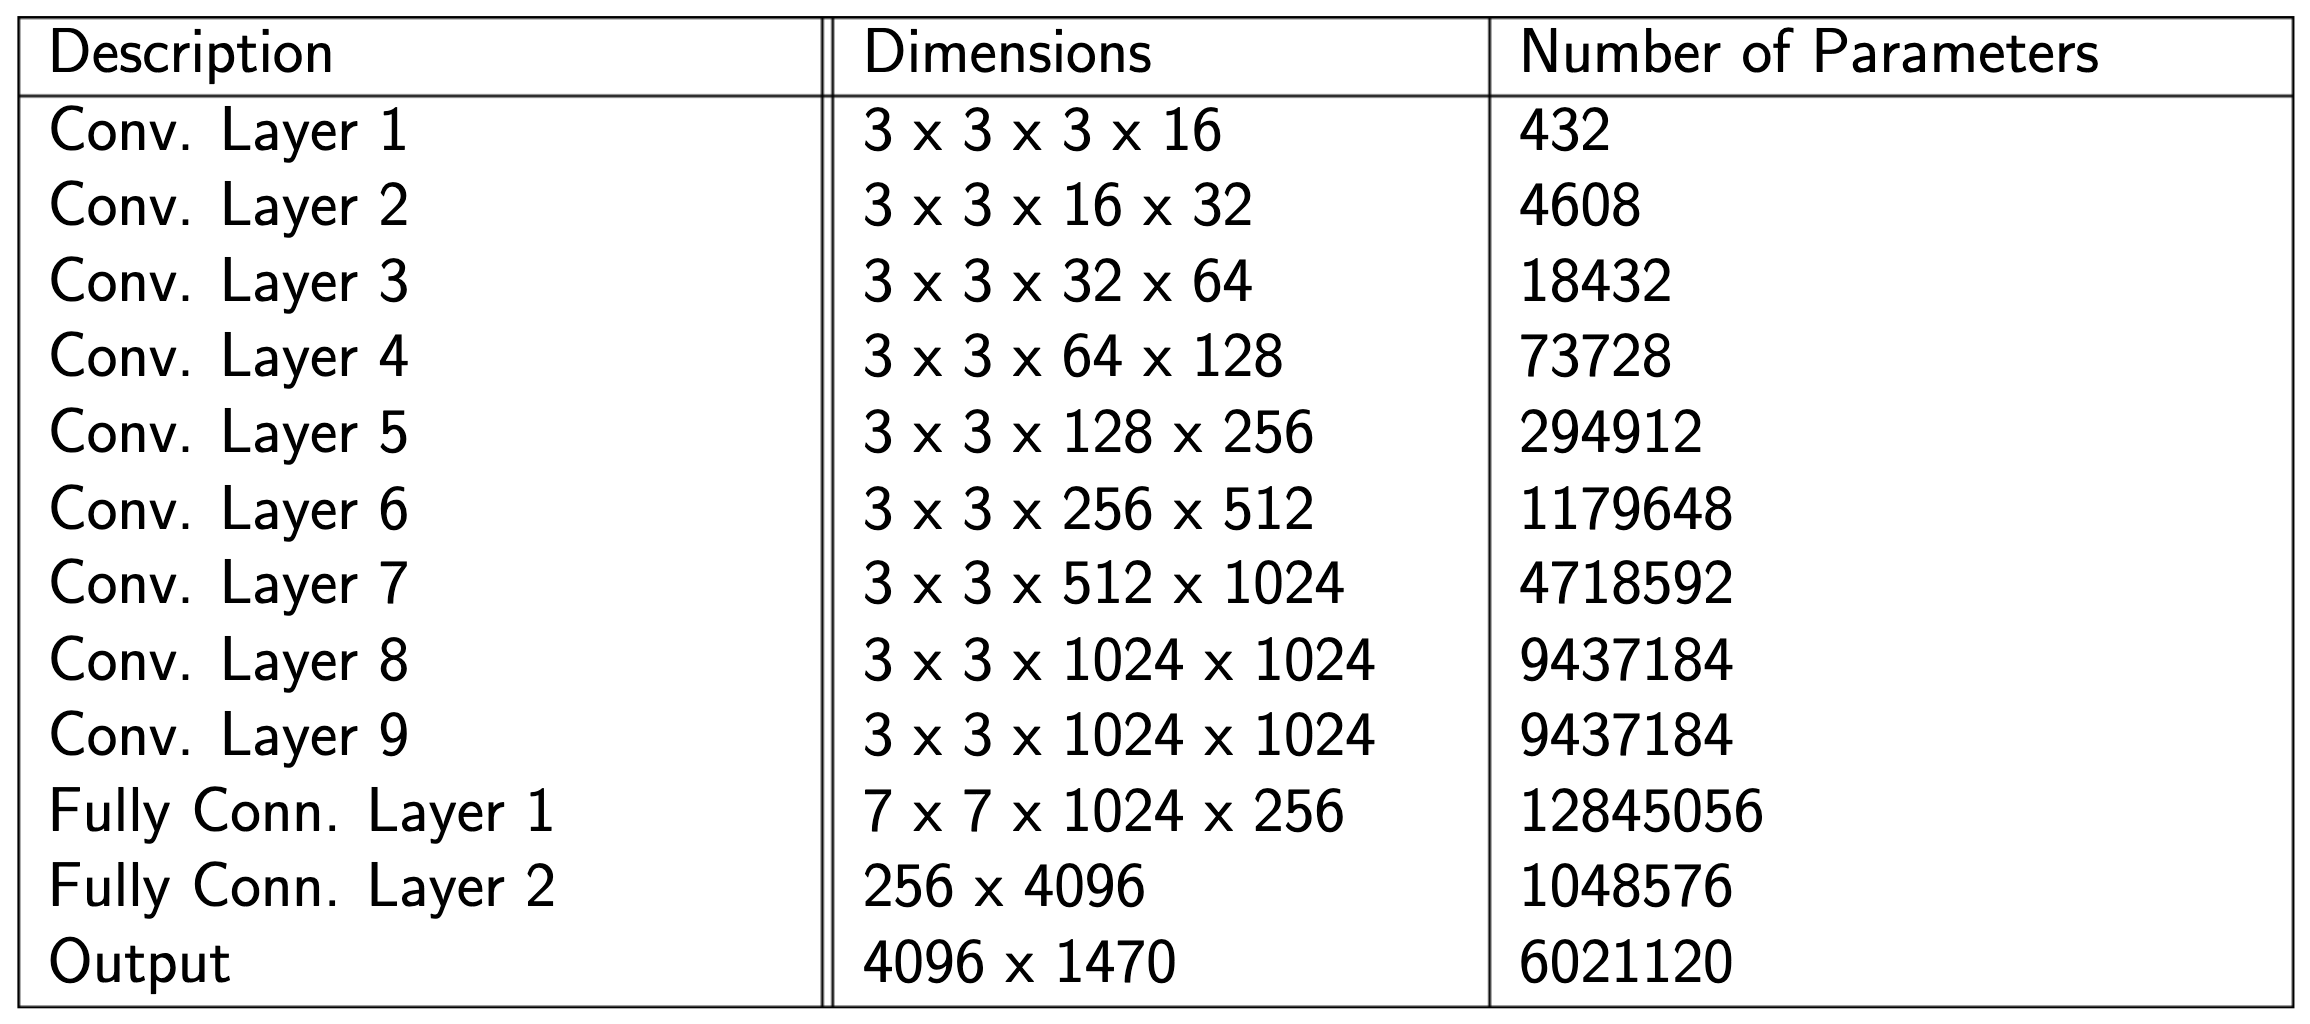

In [12]:
class CNNBlock(nn.Module):  # можно поменять на Lightning
    def __init__(self, in_channels, out_channels, is_max_pool:bool=False, **kwargs):
        
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = (3,3), padding = 1, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)  # в статье еще не знали про батчнорм, но мы то из будущего ...
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_maxpool = is_max_pool  # не после каждой свертки нужно делать maxpool
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.leakyrelu(self.batchnorm(self.conv(x)))

        if self.is_maxpool:
            x = self.maxpool(x)

        return x
    
# implememts FAST YOLO architcture
# https://www.researchgate.net/publication/326684279_Realization_and_Optimization_of_Deep_Learning_Algorithm_for_Object_Detection_and_Classification_on_FPGA
class YOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super(YOLO, self).__init__()

        self.S = S
        self.B = B
        self.C = C

        self.CNN1 = CNNBlock(in_channels = 3, out_channels = 16, is_max_pool = True)
        self.CNN2 = CNNBlock(in_channels = 16, out_channels = 32, is_max_pool = True)
        self.CNN3 = CNNBlock(in_channels = 32, out_channels = 64, is_max_pool = True)
        self.CNN4 = CNNBlock(in_channels = 64, out_channels = 128, is_max_pool = True)
        self.CNN5 = CNNBlock(in_channels = 128, out_channels = 256, is_max_pool = True)
        self.CNN6 = CNNBlock(in_channels = 256, out_channels = 512, is_max_pool = True)
        self.CNN7 = CNNBlock(in_channels = 512, out_channels = 1024, is_max_pool = False)
        self.CNN8 = CNNBlock(in_channels = 1024,out_channels = 1024, is_max_pool = False)
        self.CNN9 = CNNBlock(in_channels = 1024, out_channels = 1024, is_max_pool = False)

        self.CNN = nn.Sequential(self.CNN1, self.CNN2, self.CNN3, self.CNN4, self.CNN5,
                                self.CNN6, self.CNN7, self.CNN8, self.CNN9)
        self.FC = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(256),
            # nn.LazyBatchNorm1d(),
            nn.LeakyReLU(0.1),
            # nn.Dropout(0.2)
            nn.Linear(256, 4096),
            # nn.LazyBatchNorm1d(),
            nn.LeakyReLU(0.1),
            # nn.Dropout(0.2)
            nn.Linear(4096, self.S * self.S * (5 * self.B + self.C))
            )

    def forward(self, x):
      rez = self.CNN(x)
      rez = self.FC(x)
      return rez.view(-1, self.S, self.S, 5 * self.B + self.C)

temp_model = YOLO()
expected_output_shape = temp_model.S * temp_model.S * (5 * temp_model.B + temp_model.C)

# assert temp_model(train_dataset[0][1][None]).reshape(-1).shape[0] == train_dataset[0][1].reshape(-1).shape[0] # ????? что это вообще 
assert temp_model(train_dataset[0][0][None]).reshape(-1).shape[0] == expected_output_shape
# temp_model(train_dataset[0][0][None]).size()

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Реализуйте YoloLoss - 3 балла

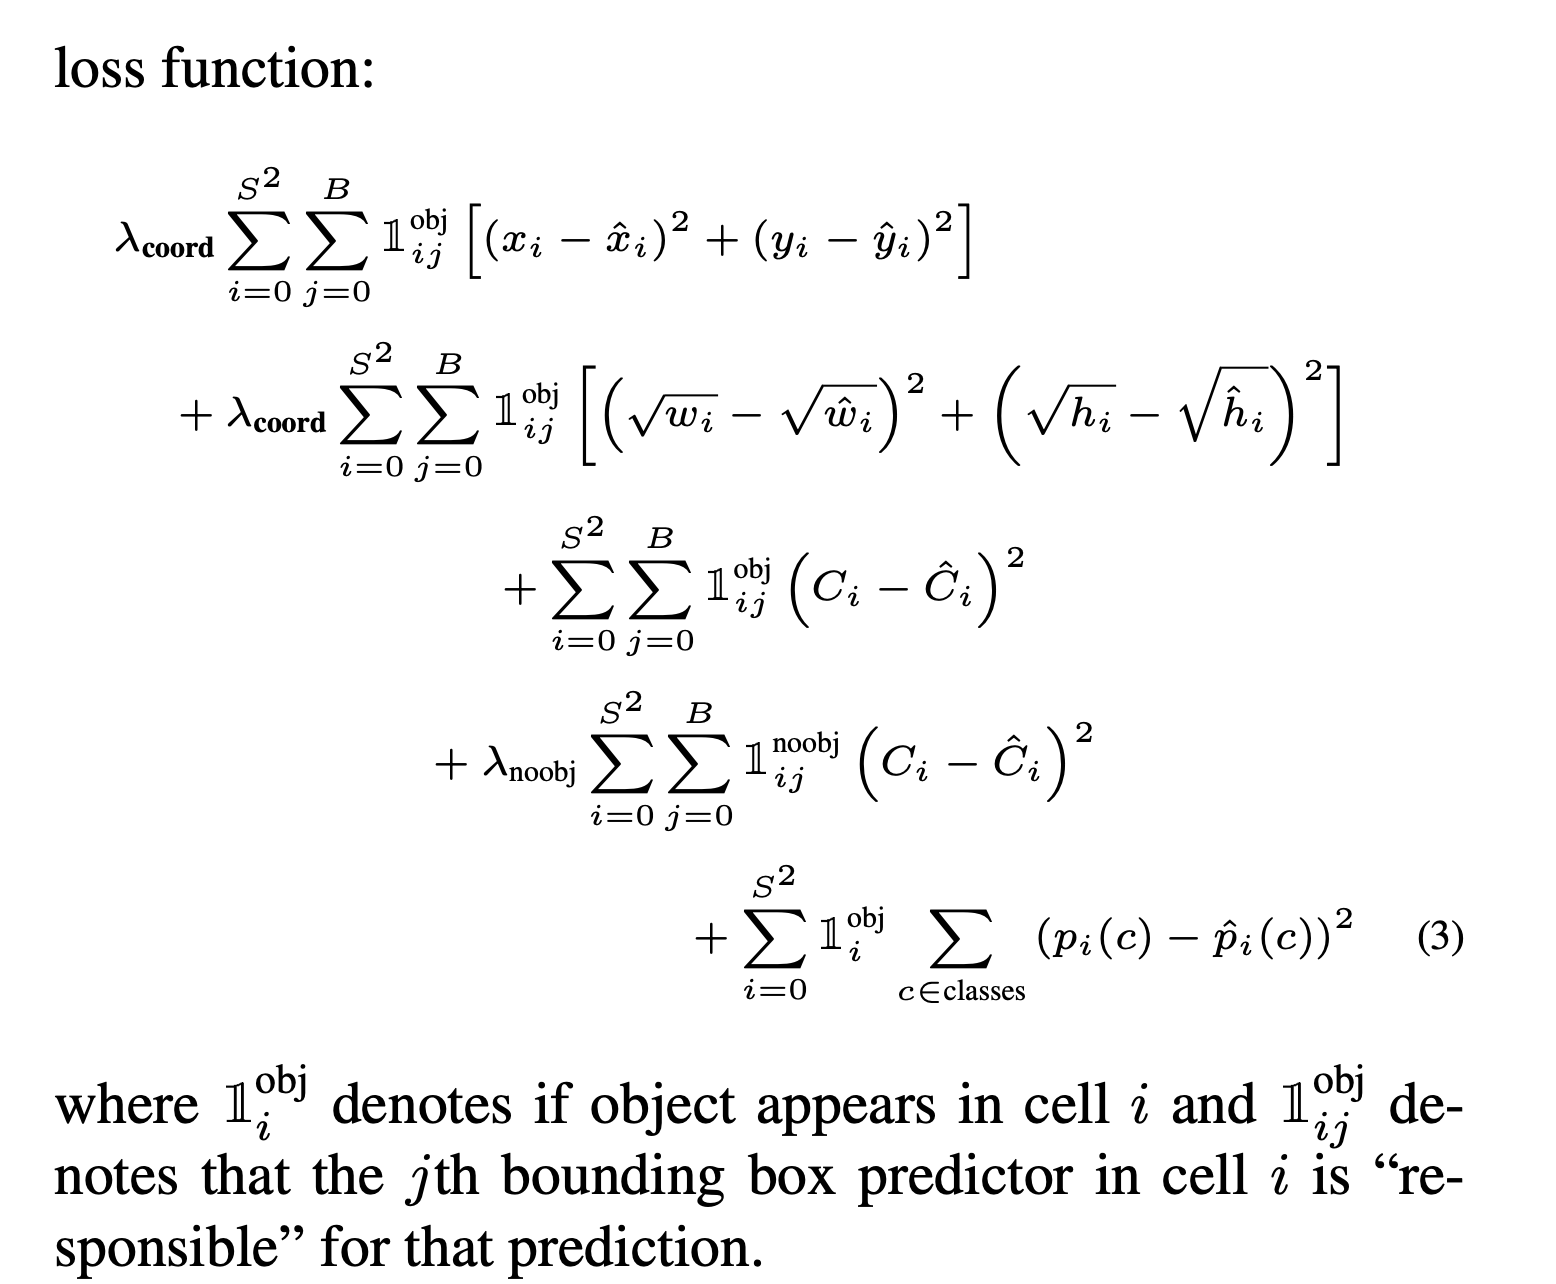

In [13]:
# https://www.kaggle.com/code/vexxingbanana/yolov1-from-scratch-pytorch
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=3):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        # predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., self.C + 1 : self.C + 5], target[..., self.C + 1 : self.C + 5])
        iou_b2 = intersection_over_union(predictions[..., self.C + 6 : self.C + 10], target[..., self.C + 1 : self.C + 5])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., self.C + 6 : self.C + 10]
                + (1 - bestbox) * predictions[..., self.C + 1 : self.C + 5]
            )
        )

        box_targets = exists_box * target[..., self.C + 1:self.C + 5]

        # Take sqrt of width, height of boxes to ensure that 
        # small boxes are evaluated equally to big ones
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., self.C + 5:self.C + 6] + (1 - bestbox) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C + 5:self.C + 6], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

In [14]:
YoloLoss().forward(temp_model(train_dataset[0][0][None]),train_dataset[0][1][None])
# train_dataset[0][1].shape

tensor(72.1152, grad_fn=<AddBackward0>)

## Реализуйте дополнительные функции из статьи - 2 балла

In [15]:
# https://www.kaggle.com/code/vexxingbanana/yolov1-from-scratch-pytorch
from collections import Counter
def non_max_suppression(bboxes, iou_threshold, threshold):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
        
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box for box in bboxes if box[0] != chosen_box[0]
            or intersection_over_union( torch.tensor(chosen_box[2:]),torch.tensor(box[2:])) < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, C=3):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2] # x_center, y_center, h, w
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(C):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)


In [23]:
# https://www.kaggle.com/code/vexxingbanana/yolov1-from-scratch-pytorch
def get_bound_boxes(loader, model, iou_threshold=.5, threshold=.4):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to('cuda')
        labels = labels.to('cuda')

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
            )

            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7, B=2, C=3):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C + B*5)
    bboxes1 = predictions[..., C + 1:C + 5]
    bboxes2 = predictions[..., C + 6:C + 10]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

## Обучите модель и посчитайте метрики для задачи детекции - 2 балла 

Несмотря на то, что в этом блоке ничего сильно нового для вас не ожидается и за него формально дается лишь два балла - провести обучение очень важно для понимания того, насколько правильно реализована ваша модель и лосс.

В процессе обучения будет видно все ли размерности совпадают, падает ли лосс и растут ли метрики целевой задачи, поэтому на практике этот пункт гораздо оказывается гораздо важнее.

In [17]:
class YOLOLearner(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()

        self.model = YOLO()
        self.loss = YoloLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        pred = self.model(images)
        loss = self.loss(pred, target)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return {'loss':loss}

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        pred = self.model(images)
        loss = self.loss(pred, target)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return {'loss':loss}

    def validation_epoch_end(self, val_step_outputs):
        avg_val_loss = torch.tensor([x['loss'] for x in val_step_outputs]).mean()
        self.log("val_loss", avg_val_loss, prog_bar=True)
        return {'val_loss':avg_val_loss}

## Посчитайте метрики задачи детекции на валидационной выборке

Попробуйте понять насколько хороши ваши показатели. Если числа кажутся подозрительно низкими - возможно вам стоит перепроверить ваше решение. 

#Sanity check: overfitting small dataset

In [ ]:
train_dataloader = DataLoader(
    dataset=[next(iter(train_dataset)) for i in range(16)],
    batch_size= 4,
    shuffle=True)

val_dataloader = DataLoader(
    dataset=[next(iter(val_dataset)) for i in range(16)],
    batch_size=4, 
    shuffle=False
    )

In [21]:
wandb.init(project="iad_hw3")
wandb_logger = WandbLogger()

yolo_learner = YOLOLearner()
trainer = pl.Trainer(logger=wandb_logger, max_epochs = 40, accelerator=device, devices=1,log_every_n_steps=4)
trainer.fit(yolo_learner, train_dataloader, val_dataloader)
wandb.finish()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:411: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(
INFO:pytorch_lightning.callbacks.model_summa

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▂▂▂▂▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,39
train_loss_epoch,68.18779
train_loss_step,145.86687
trainer/global_step,159
val_loss,5468.18311


Report:

https://wandb.ai/lemondoge/iad_hw3/reports/SANITY-CHECK--VmlldzozMTgxNTU4?accessToken=f08ej33mn4ym9qys3a14h5sp70q5tvpdapqd4jix8g9boz6og7h6al9a6vrssdlp

#Fitting the whole dataset

In [18]:
train_dataloader = DataLoader(
    dataset=[next(iter(train_dataset)) for i in range(32)],
    batch_size= 4,
    shuffle=True)

val_dataloader = DataLoader(
    dataset=[next(iter(val_dataset)) for i in range(32)],
    batch_size=4, 
    shuffle=False
    )

In [ ]:
wandb.init(project="iad_hw3")
wandb_logger = WandbLogger()

yolo_learner = YOLOLearner()
trainer = pl.Trainer(logger=wandb_logger, max_epochs = 100, accelerator=device, devices=1,log_every_n_steps=4)
trainer.fit(yolo_learner, train_dataloader, val_dataloader)
wandb.finish()

Report:

https://wandb.ai/lemondoge/iad_hw3/reports/General-Training-Report--VmlldzozMTgyNzg0?accessToken=9rlwv0m71axf1ndvycvpyfwz0u2alf8z4ri37dn1a0ph00cnj0cohozt7nll6evl

## Визуализируйте предсказанные bounding box'ы для любых пяти картинок из __валидационного__ датасета.

In [18]:
train_dataloader = DataLoader(
    dataset=[next(iter(train_dataset)) for i in range(32)],
    batch_size= 4,
    shuffle=True)

val_dataloader = DataLoader(
    dataset=[next(iter(val_dataset)) for i in range(32)],
    batch_size=4, 
    shuffle=False
    )

In [19]:
wandb.init(project="iad_hw3")
wandb_logger = WandbLogger()

yolo_learner = YOLOLearner()
trainer = pl.Trainer(logger=wandb_logger, max_epochs = 51, accelerator=device, devices=1,log_every_n_steps=4)
trainer.fit(yolo_learner, train_dataloader, val_dataloader)
wandb.finish()

wandb: Currently logged in as: lemondoge. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/pyt

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss_epoch,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▄▅▃▂▂▄▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▃▃▂▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,22
train_loss_epoch,136.58925
train_loss_step,77.13224
trainer/global_step,183
val_loss,9732.63281


In [57]:
val_dataloader = DataLoader(
    dataset=[next(iter(val_dataset)) for i in range(5)],
    batch_size=1, 
    shuffle=False
    )
boxes_pred = get_bound_boxes(val_dataloader, yolo_learner.model)

# https://wandb.ai/lemondoge/iad_hw3/reports/---VmlldzozMTgyOTgy?accessToken=k7ojcliof4htcfduhm1jt98si088ld6uxp5b81mh3idmp1a2rpt3fw52fdd2dwfi

In [27]:
# https://albumentations.ai/docs/examples/example_bboxes/
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    img_h, img_w, img_d = img.shape
    x_center, y_center, w, h = bbox
    x_min = int((x_center - w/2) * img_w)
    x_max = int((x_center + w/2)* img_w)
    y_min = int((y_center + h/2) * img_h)
    y_max = int((y_center - h/2) * img_h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [ ]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}
tag2class = {v: k for k, v in class2tag.items()}

import pprint
with open('/content/data/test/mixed_24.xml', 'rb') as xml:
  raw = xmltodict.parse(xml, process_namespaces=True)['annotation']
  img_dimentions = raw['size']
  width = float(img_dimentions['width'])
  height = float(img_dimentions['height'])

  if width == 0 or height == 0:
    height, width, dim = np.array(Image.open('/content/data/test/mixed_24.jpg')).shape

  objects = raw['object']
  # single object in image
  if type(objects) is dict:
    objects = [objects]

  bounds = []
  labels = []
  for obj in objects:
    bndbx = obj['bndbox']
    bounds.append([(float(bndbx['xmax']) + float(bndbx['xmin']))/(2 * width), # center_x
                         (float(bndbx['ymax']) + float(bndbx['ymin']))/(2 * height), # center_y
                         (float(bndbx['xmax']) - float(bndbx['xmin']))/width, # width
                         (float(bndbx['ymax']) - float(bndbx['ymin']))/height # height
                         ])
    labels.append(class2tag[obj['name']])
  # bounds = torch.FloatTensor(bounds)
  # labels = torch.LongTensor(labels)
  # pprint.pprint(img_dimentions)
  # print(widht, height)
  # print(bounds, labels)
  # print(torch.cat((bounds, labels.view(-1,1)), 1))
  image = np.array(Image.open('/content/data/test/mixed_24.jpg').convert("RGB"))
  visualize(image, bounds, labels, tag2class)

NameError: ignored

In [ ]:
image, targets = next(iter(val_dataset))
preds = ## YOUR CODE

In [ ]:
from PIL import ImageDraw

image = torchvision.transform.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in targets[0]:
    ## YOUR CODE
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])

for box in preds[0]:
    ## YOUR CODE
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image